<a href="https://www.kaggle.com/code/aneeshgrover/basic-regression-tss24-competition-4?scriptVersionId=185806771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

import lightgbm as LGBMRegressor
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tss24-competition-4/sample_submission.csv
/kaggle/input/tss24-competition-4/train.csv
/kaggle/input/tss24-competition-4/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/tss24-competition-4/train.csv", index_col = 'id')
train = pd.get_dummies(train, dtype = float)
train

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_F,Sex_I,Sex_M
id,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1.0,0.0,0.0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1.0,0.0,0.0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.0,1.0,0.0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.0,0.0,1.0
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,0.0,0.0,1.0
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,0.0,0.0,1.0
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,0.0,1.0,0.0


In [3]:
correlationMatrix = train.corr()
correlationMatrix

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_F,Sex_I,Sex_M
Length,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.623786,0.365578,-0.656415,0.315624
Diameter,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.636832,0.370765,-0.664771,0.319131
Height,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.665772,0.367521,-0.645291,0.302475
Whole weight,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.617274,0.368940,-0.651185,0.307096
Whole weight.1,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.515067,0.343068,-0.619272,0.299513
Whole weight.2,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.588954,0.370807,-0.646484,0.300536
Shell weight,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.694766,0.372127,-0.648101,0.300911
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,1.000000,0.296411,-0.516591,0.240048
Sex_F,0.365578,0.370765,0.367521,0.368940,0.343068,0.370807,0.372127,0.296411,1.000000,-0.487569,-0.463848
Sex_I,-0.656415,-0.664771,-0.645291,-0.651185,-0.619272,-0.646484,-0.648101,-0.516591,-0.487569,1.000000,-0.547320


<function matplotlib.pyplot.show(close=None, block=None)>

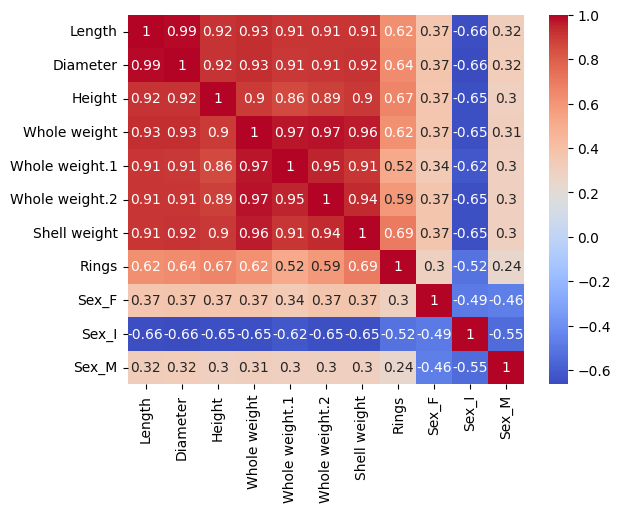

In [4]:
sns.heatmap(correlationMatrix, annot = True, cmap = 'coolwarm')
plt.show

In [5]:
def rmsleScore(Predicted, Actual):
    inner = (np.log(Predicted + 1) - np.log(Actual + 1)) ** 2
    mean = inner.mean()
    rmsle = np.sqrt(mean)
    return rmsle

In [6]:
features = train.drop(columns = ['Rings'])
target = train['Rings']

scaler = StandardScaler() 
features = scaler.fit_transform(features)

In [7]:
features = train.drop(columns = ['Rings'])
target = train['Rings']
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
#model = Ridge(alpha=1.0).fit(X_train, Y_train)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

model = GradientBoostingRegressor(**params)
cv = cross_val_score(model, features, target, scoring = 'neg_mean_squared_log_error' )
print(np.sqrt(-np.mean(cv)))
model.fit(X_train, Y_train)

#model = XGBRegressor().fit(features, target)

0.15331524246713862


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [8]:

PredictionsSmth = model.predict(X_test)
PredictionsSmth[PredictionsSmth < 0] = 0
print(PredictionsSmth.min)

smthScore = rmsleScore(PredictionsSmth, Y_test)
print(f"Smth Score : {smthScore}")


<built-in method min of numpy.ndarray object at 0x79a408cd9e30>
Smth Score : 0.15585821034367017


In [9]:
'''
for Name, model in models.items():
    
    model = model.fit(features, target)
    print(f"{Name} : \n")
    
    PredictionsSmth = model.predict(features)
    PredictionsSmth[PredictionsSmth < 0] = 1
    print(PredictionsSmth.min)

    smthScore = rmsleScore(PredictionsSmth, target)
    print(f"Smth Score : {smthScore}")
'''

'\nfor Name, model in models.items():\n    \n    model = model.fit(features, target)\n    print(f"{Name} : \n")\n    \n    PredictionsSmth = model.predict(features)\n    PredictionsSmth[PredictionsSmth < 0] = 1\n    print(PredictionsSmth.min)\n\n    smthScore = rmsleScore(PredictionsSmth, target)\n    print(f"Smth Score : {smthScore}")\n'

In [10]:
'''
for Name, model in models.items():
    
    model = model.fit(X_train, Y_train)
    print(f"{Name} : \n")
    
    PredictionsTrain = model.predict(X_train)
    PredictionsTrain[PredictionsTrain < 0] = 1
    print(PredictionsTrain.min)

    trainScore = rmsleScore(PredictionsTrain, Y_train)

    PredictionsTest = model.predict(X_test)
    PredictionsTest[PredictionsTest < 0] = 1
    print(PredictionsTest.min)

    testScore = rmsleScore(PredictionsTest, Y_test)


    print(f"Train Split Score : {trainScore}")
    print(f"Test Split Score : {testScore}")
'''

'\nfor Name, model in models.items():\n    \n    model = model.fit(X_train, Y_train)\n    print(f"{Name} : \n")\n    \n    PredictionsTrain = model.predict(X_train)\n    PredictionsTrain[PredictionsTrain < 0] = 1\n    print(PredictionsTrain.min)\n\n    trainScore = rmsleScore(PredictionsTrain, Y_train)\n\n    PredictionsTest = model.predict(X_test)\n    PredictionsTest[PredictionsTest < 0] = 1\n    print(PredictionsTest.min)\n\n    testScore = rmsleScore(PredictionsTest, Y_test)\n\n\n    print(f"Train Split Score : {trainScore}")\n    print(f"Test Split Score : {testScore}")\n'

In [11]:
test = pd.read_csv("/kaggle/input/tss24-competition-4/test.csv", index_col = 'id')
test = pd.get_dummies(test, dtype = float)
test

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_F,Sex_I,Sex_M
id,,,,,,,,,,
90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0.0,0.0,1.0
90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0.0,0.0,1.0
90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0.0,0.0,1.0
90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0.0,0.0,1.0
90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,0.0,1.0,0.0
151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.0,0.0,0.0
151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,0.0,1.0,0.0


In [12]:
Predictions = model.predict(test)
Predictions[Predictions < 0] = 1

Submission = pd.DataFrame({
    "Rings" : Predictions}, 
    index = test.index)

Submission
Submission.to_csv("Submission.csv")